**Data Mining Project, midterm 2021/2022**




**Authors:** Niko Dalla Noce, Alessandro Ristori, Giuseppe Lombardi

#**Task 1.2 Data Preparation**

##**Import the libraries and load the cleaned dataset**

First we have to import the necessary libraries to work within our project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import scipy
import seaborn as sn
import re
import datetime
import math
import plotly.graph_objs as plt_go
import requests

We assume that the dataset is inside a zip file, so we need to extract it.

In [2]:
import zipfile
with zipfile.ZipFile("preparation_data.zip", 'r') as zip_ref:
     zip_ref.extractall()

**Load the players datasets and the cleaned matches dataset**

In [3]:
df_male = pd.read_csv("male_players.csv", sep=",")  # dataframe of male players
df_female = pd.read_csv("female_players.csv", sep=",")  # dataframe of female players
df_matches = pd.read_parquet("cleaned_tennis_matches.gzip")  # cleaned dataframe of matches
df_matches

,tourney_id,surface,tourney_date,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,106421,Daniil Medvedev,R,198,RUS,22.885695,6-4 3-6 6-2,3,F,3,3,77,44,31,17,13,3,6,8,6,100,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,7-6(6) 6-2,3,SF,10,1,52,33,28,14,10,0,1,17,2,77,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Hard,2018-12-31,105453,Kei Nishikori,R,178,JPN,29.004791,104871,Jeremy Chardy,R,188,FRA,31.882272,6-2 6-2,3,SF,2,2,47,33,26,9,8,2,2,10,3,46,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Hard,2018-12-31,104542,Jo-Wilfried Tsonga,R,188,FRA,33.705681,200282,Alex De Minaur,R,183,AUS,19.868583,6-4 7-6(2),3,QF,12,2,68,43,34,15,11,4,5,1,2,81,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Hard,2018-12-31,106421,Daniil Medvedev,R,198,RUS,22.885695,105683,Milos Raonic,R,196,CAN,28.010951,6-7(2) 6-3 6-4,3,QF,12,3,105,68,48,25,16,8,8,29,5,94,56,46,19,15,2,4,16,1977,18,1855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177499,2020-2023,Clay,2020-08-31,215337,Olga Danilovic,L,<NA>,SRB,19.603012,204420,Marcela Zacarias,R,<NA>,MEX,26.433949,6-3 6-1,3,R128,1,2,45,20,15,14,8,3,5,0,0,64,51,20,7,8,3,9,174,363,259,225
177500,2020-2023,Clay,2020-08-31,202457,Bibiane Schoofs,R,170,NLD,32.301164,205918,Ulrikke Eikeri,U,<NA>,NOR,27.707050,5-7 6-0 6-4,3,R128,3,5,93,62,36,15,14,4,9,1,3,84,48,22,18,14,3,11,190,326,250,245
177501,2020-2023,Clay,2020-08-31,212044,Katharina Gerlach,R,<NA>,DEU,22.529774,202653,Denisa Allertova,R,<NA>,CZE,27.485284,6-2 6-1,3,R128,5,5,45,27,23,10,8,2,3,0,0,40,28,13,2,7,1,6,240,251,239,252
177502,2020-2023,Clay,2020-08-31,206037,Daniela Seguel,U,<NA>,CHL,27.791923,214684,Katherine Sebov,U,<NA>,CAN,21.653662,6-2 6-2,3,R128,0,0,54,38,23,8,8,3,5,0,4,59,46,18,5,8,4,10,224,269,257,233


In [4]:
df_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81982 entries, 0 to 177503
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_id          81982 non-null  object        
 1   surface             81982 non-null  object        
 2   tourney_date        81982 non-null  datetime64[ns]
 3   winner_id           81982 non-null  Int64         
 4   winner_name         81982 non-null  object        
 5   winner_hand         81982 non-null  object        
 6   winner_ht           43894 non-null  Int64         
 7   winner_ioc          81982 non-null  object        
 8   winner_age          81968 non-null  float64       
 9   loser_id            81982 non-null  Int64         
 10  loser_name          81982 non-null  object        
 11  loser_hand          81982 non-null  object        
 12  loser_ht            35436 non-null  Int64         
 13  loser_ioc           81982 non-null  object   

##**Build the player's profiles**

Our task is to build a new dataset on which we will apply different clustering algorithms, for such purpose we need to extract and create indicators that could be useful for the next task, but for now let's work with the statistics coming from the data understanding task with some others that we thought could be useful.

###**Create the dataframe**

The first feature we need for the players profiles is the name, this is straightforward as we only have to take such attribute from the matches dataset, we also need to create the players dataframe.

In [5]:
regex = "[ ',.]+"
df_matches['winner_name'] = df_matches['winner_name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))
df_matches['loser_name'] = df_matches['loser_name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))

players = df_matches['winner_name'].append(df_matches['loser_name']).drop_duplicates()
players

0              kei nishikori
1            daniil medvedev
3         jo-wilfried tsonga
5              jeremy chardy
8             alex de minaur
                 ...        
177178         ellie douglas
177223      brittany collens
177445      barbora palicova
177446    kristyna lavickova
177479       darja vidmanova
Length: 4255, dtype: object

###**Assign sex**

To assign the sex to each player we need to look into the male and female dataset, the names could be written a little bit different from the matches dataset (and that means that a player may have no sex assigned), that's why we modified the name using regex.

In [6]:
def assign_sex(players, regex):
    df_male.dropna(inplace=True)
    df_male.drop_duplicates(inplace=True)
    df_female.dropna(inplace=True)
    df_female.drop_duplicates(inplace=True)
    df_players_m = pd.DataFrame()
    df_players_f = pd.DataFrame()

    df_players_m['name'] = df_male['name'] + ' ' + df_male['surname']
    df_players_m['sex'] = "M"
    df_players_f['name'] = df_female['name'] + ' ' + df_female['surname']
    df_players_f['sex'] = "F"

    df_m_f = df_players_m.append(df_players_f)
    df_m_f['name'] = df_m_f['name'].apply(lambda x: re.sub(regex, ' ', str(x).lower()))

    players_no_sex = players[~players.isin(df_m_f['name'])]
    df_m_f = df_m_f[df_m_f['name'].isin(players)]
    return df_m_f, players_no_sex

In [7]:
df_players, df_players_no_sex = assign_sex(players, regex)

There are players with no sex found, many of them have their name written in a different way in the male or female datasets.

In [8]:
print("Players with no sex found: {0}\n{1}".format(len(df_players_no_sex), df_players_no_sex))

Players with no sex found: 26
3                   jo-wilfried tsonga
59                      cristian garin
105                      stan wawrinka
168                      antoine hoang
185                       taylor fritz
221                  diego schwartzman
306                     frances tiafoe
563                     pedro martinez
597                       lloyd harris
892                      franko skugor
1524                          j j wolf
1843                daniel elahi galan
4875                      joao menezes
6777               juan pablo varillas
7921                  khumoun sultanov
7941                       holger rune
11229                  jurabek karimov
11334                  evgenii tiurnev
33451            christopher o connell
34781                        sam groth
67053                  alexandar lazov
69104                     david o hare
69985                      kuan-yi lee
73063                       ben patael
101280    andres artunedo martinav

Each one of them is male except Alona Fomina who is female, let's assign the correct sex to all of them.

In [9]:
frame = {'name': df_players_no_sex, 'sex': 'M'}
df_players_no_sex = pd.DataFrame(frame)
df_players_no_sex.loc[df_players_no_sex['name'] == 'alona fomina', 'sex'] = 'F'
df_players = df_players.append(df_players_no_sex, ignore_index=True)
df_players

,name,sex
0,alexander zverev,M
1,jeff greenwald,M
2,agustin moreno,M
3,martin damm,M
4,wei yu su,M
...,...,...
4254,david o hare,M
4255,kuan-yi lee,M
4256,ben patael,M
4257,andres artunedo martinavarro,M


There may be players with two sexes assigned.

In [10]:
df_players["name"].value_counts()
num_sexes = df_players["name"].value_counts().to_frame().rename(columns={"name": "sex"})
print(num_sexes)
players_with_two_sexes = list(num_sexes[num_sexes["sex"] > 1].index)
print(players_with_two_sexes)

                        sex
iancu lustinian ghinda    2
kuan yi lee               2
austin smith              2
yang liu                  2
daniel nguyen             1
...                     ...
kevin griekspoor          1
bradley mousley           1
denys molchanov           1
ondrej styler             1
silvia soler espinosa     1

[4255 rows x 1 columns]
['iancu lustinian ghinda', 'kuan yi lee', 'austin smith', 'yang liu']


We found their real sex by looking online, so we can fix the issue.

In [11]:
female_players = ["yang liu", "kuan yi lee"]
male_players = ["austin smith", "iancu lustinian ghinda"]
df_players.loc[df_players["name"].isin(male_players), "sex"] = "M"
df_players.loc[df_players["name"].isin(female_players), "sex"] = "F"
df_players.drop_duplicates(inplace=True)

In [12]:
df_players["name"].value_counts()

james ward                  1
lisa zaar                   1
marta custic                1
daniel nguyen               1
alonso alejandro delgado    1
                           ..
kevin griekspoor            1
bradley mousley             1
denys molchanov             1
ondrej styler               1
silvia soler espinosa       1
Name: name, Length: 4255, dtype: int64

M    3002
F    1253
Name: sex, dtype: int64


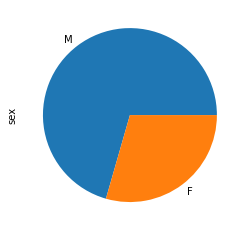

In [13]:
sex_distribution = df_players[["name", "sex"]]["sex"].value_counts()
print(sex_distribution)
sex_distribution.plot(kind="pie");

###**Assign age**

Dobbiamo ottenere l'età attuale.

In [14]:
'''def fill_age_with_actual_values():
    win_no_age = df_matches[pd.isna(df_matches['winner_age'])]['winner_name'].drop_duplicates()
    win_with_age = df_matches[df_matches['winner_age'].notna()][
        ['winner_name', 'winner_age', 'tourney_date']].drop_duplicates(subset='winner_name')
    win_never_age = win_no_age[~win_no_age.isin(win_with_age['winner_name'])]
    loser_with_age = df_matches[df_matches['loser_age'].notna()][['loser_name', 'loser_age', 'tourney_date']]
    ris = loser_with_age[loser_with_age['loser_name'].isin(win_never_age)].drop_duplicates(subset='loser_name')
    ris.rename(columns={'loser_name': 'winner_name', 'loser_age': 'winner_age'}, inplace=True)
    win_with_age = win_with_age.append(ris)

    loser_no_age = df_matches[pd.isna(df_matches['loser_age'])]['loser_name'].drop_duplicates()
    loser_with_age = df_matches[df_matches['loser_age'].notna()][
        ['loser_name', 'loser_age', 'tourney_date']].drop_duplicates(subset='loser_name')
    loser_never_age = loser_no_age[~loser_no_age.isin(loser_with_age['loser_name'])]
    winner_with_age = df_matches[df_matches['winner_age'].notna()][['winner_name', 'winner_age', 'tourney_date']]
    ris = winner_with_age[winner_with_age['winner_name'].isin(loser_never_age)].drop_duplicates(subset='winner_name')
    loser_with_age.rename(columns={'loser_name': 'winner_name', 'loser_age': 'winner_age'}, inplace=True)
    loser_with_age = loser_with_age.append(ris)
    ris = win_with_age.append(loser_with_age).drop_duplicates(subset='winner_name')
    ris.rename(columns={'winner_name': 'name', 'winner_age': 'age'}, inplace=True)
    return ris'''


def __birth_date(age, a_date):
    days = datetime.timedelta(math.ceil(age * 365) + int(age / 4))
    return a_date - days


def birth_date_calc(player_with_ages, new_ds):
    new_ds.insert(len(new_ds.columns), 'birth_date', np.NaN)
    for _, x in player_with_ages.iterrows():
        b_d = __birth_date(x['age'], x['tourney_date'])
        new_ds.loc[new_ds['name'] == x['name'], 'birth_date'] = b_d
    new_ds['birth_date'] = pd.to_datetime(new_ds['birth_date'], errors='coerce').dt.date

def retrieve_age_and_tourdate(df_matches):
  win_with_age = df_matches[df_matches['winner_age'].notna()][
        ['winner_name', 'winner_age', 'tourney_date']]

  loser_with_age = df_matches[df_matches['loser_age'].notna()][
      ['loser_name', 'loser_age', 'tourney_date']]
  loser_with_age.rename(columns={'loser_name': 'winner_name', 'loser_age': 'winner_age'}, inplace=True)

  ris = win_with_age.append(loser_with_age).drop_duplicates(subset='winner_name')
  ris.rename(columns={'winner_name': 'name', 'winner_age': 'age'}, inplace=True)
  return ris
        

In [15]:
player_with_ages = retrieve_age_and_tourdate(df_matches)
print("There are {0} players with no known age".format(len(players)-len(player_with_ages)))
birth_date_calc(player_with_ages, df_players)

There are 56 players with no known age


In [16]:
df_players

,name,sex,birth_date
0,alexander zverev,M,1997-04-20
1,jeff greenwald,M,1966-11-10
2,agustin moreno,M,1967-03-31
3,martin damm,M,2003-09-30
4,wei yu su,M,1976-01-12
...,...,...,...
4254,david o hare,M,1990-06-01
4255,kuan-yi lee,M,1996-09-09
4256,ben patael,M,1997-06-09
4257,andres artunedo martinavarro,M,1993-09-14


In [17]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4255 entries, 0 to 4258
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        4255 non-null   object
 1   sex         4255 non-null   object
 2   birth_date  4199 non-null   object
dtypes: object(3)
memory usage: 133.0+ KB


###**Assign ioc**

From the data understanding task we know that each player has only one ioc, so we only have to assign them the right one by looking at the match dataset.

In [18]:
w_ioc = df_matches[["winner_name", "winner_ioc"]].rename(columns={"winner_name": "name", "winner_ioc": "ioc"})
l_ioc = df_matches[["loser_name", "loser_ioc"]].rename(columns={"loser_name": "name", "loser_ioc": "ioc"})
players_ioc = w_ioc.append(l_ioc).drop_duplicates()
players_ioc

,name,ioc
0,kei nishikori,JPN
1,daniil medvedev,RUS
3,jo-wilfried tsonga,FRA
5,jeremy chardy,FRA
8,alex de minaur,AUS
...,...,...
177178,ellie douglas,USA
177223,brittany collens,USA
177445,barbora palicova,CZE
177446,kristyna lavickova,CZE


In [19]:
df_players.insert(len(df_players.columns), 'ioc', np.NaN)
for _, player in players_ioc.iterrows():
    df_players.loc[df_players["name"] == player["name"], "ioc"] = player["ioc"]

Let's show how many player are in each country.

In [20]:
ioc_distribution = df_players["ioc"].value_counts()
ioc_distribution

USA    425
ITA    259
FRA    239
AUS    174
DEU    168
      ... 
WSM      1
HTI      1
GUD      1
AND      1
COD      1
Name: ioc, Length: 123, dtype: int64

In [21]:
fig = plt_go.Figure(
    data=plt_go.Choropleth(
        locations=ioc_distribution.index,
        z=ioc_distribution, 
        colorbar_title='Player per ioc',))
fig.update_layout(title_text='Number of players per country')

fig.show()

###**Assign height**

In [22]:
w_ht = df_matches[["winner_name", "winner_ht"]].rename(columns={"winner_name": "name", "winner_ht": "ht"})
l_ht = df_matches[["loser_name", "loser_ht"]].rename(columns={"loser_name": "name", "loser_ht": "ht"})
players_ht = w_ht.append(l_ht).drop_duplicates()
players_ht

,name,ht
0,kei nishikori,178
1,daniil medvedev,198
3,jo-wilfried tsonga,188
5,jeremy chardy,188
8,alex de minaur,183
...,...,...
177178,ellie douglas,<NA>
177223,brittany collens,<NA>
177445,barbora palicova,<NA>
177446,kristyna lavickova,<NA>


In [23]:
df_players.insert(len(df_players.columns), 'ht', np.NaN)
df_players["ht"] = df_players["ht"].astype("Int64", errors="ignore")
for _, player in players_ht[players_ht["ht"].notna()].iterrows():
    df_players.loc[df_players["name"] == player["name"], "ht"] = player["ht"]

In [24]:
print("Players with no height: {0}".format(len(df_players[df_players["ht"].isna()])))

Players with no height: 3721


In [25]:
players_no_ht = df_players[df_players["ht"].isna()]
players_no_ht

,name,sex,birth_date,ioc,ht
1,jeff greenwald,M,1966-11-10,USA,<NA>
3,martin damm,M,2003-09-30,USA,<NA>
4,wei yu su,M,1976-01-12,TWN,<NA>
5,gergely kisgyorgy,M,1976-03-08,HUN,<NA>
17,alessandro motti,M,1979-02-28,ITA,<NA>
...,...,...,...,...,...
4254,david o hare,M,1990-06-01,IRL,<NA>
4255,kuan-yi lee,M,1996-09-09,TWN,<NA>
4256,ben patael,M,1997-06-09,ISR,<NA>
4257,andres artunedo martinavarro,M,1993-09-14,ESP,<NA>


In [26]:
p_ht_ioc = df_players.groupby(["ioc", "sex"]).count()["ht"]
p_ht_ioc.mean() + 3 * p_ht_ioc.std()

17.12721738326431

In [27]:
p_ht_ioc = df_players.groupby(["ioc", "sex"]).count()["ht"]
p_mean_ht_ioc = df_players.groupby(["ioc", "sex"]).mean()["ht"] 
p_std_ht_ioc = df_players.groupby(["ioc", "sex"]).std()["ht"]
p_mean_ht_sex = df_players.groupby("sex").mean()["ht"] 
p_std_ht_sex = df_players.groupby("sex").std()["ht"]
for _, player in players_no_ht.iterrows():
    ioc, sex = player[["ioc", "sex"]]
    n_players = p_ht_ioc.loc[(ioc, sex)]
    if n_players > 10:
        mean = p_mean_ht_ioc.loc[(ioc,  sex)]
        std = p_std_ht_ioc.loc[(ioc, sex)]
    else:
        mean = p_mean_ht_sex.loc[sex]
        std = p_std_ht_sex.loc[sex]

    df_players.loc[df_players["name"]==player["name"], "ht"] = int(np.random.normal(mean, std))

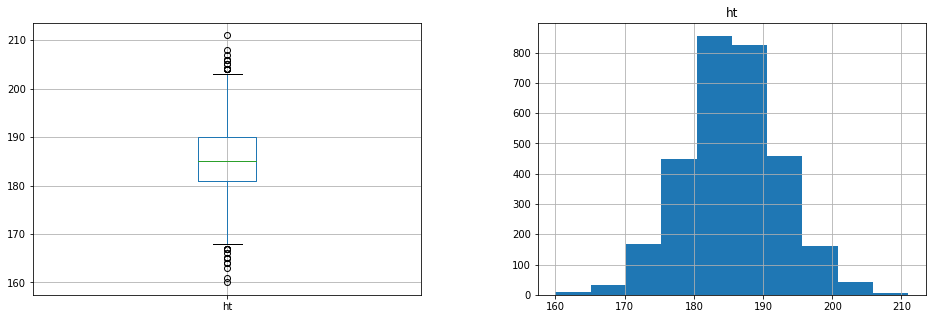

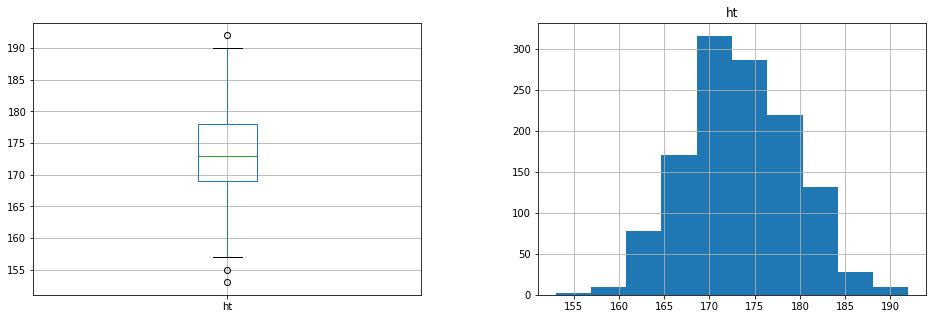

In [28]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="M"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="M"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players[df_players["sex"]=="F"].boxplot(column="ht", ax=ax1)
df_players[df_players["sex"]=="F"].hist(column="ht", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

###**Assign hand**

In [29]:
w_hand = df_matches[["winner_name", "winner_hand"]].rename(columns={"winner_name": "name", "winner_hand": "hand"})
l_hand = df_matches[["loser_name", "loser_hand"]].rename(columns={"loser_name": "name", "loser_hand": "hand"})
players_hand = w_hand.append(l_hand).drop_duplicates()
players_hand

,name,hand
0,kei nishikori,R
1,daniil medvedev,R
3,jo-wilfried tsonga,R
5,jeremy chardy,R
8,alex de minaur,R
...,...,...
177178,ellie douglas,U
177223,brittany collens,R
177445,barbora palicova,R
177446,kristyna lavickova,U


In [30]:
df_players.insert(len(df_players.columns), 'hand', np.NaN)
for _, player in players_hand.iterrows():
    df_players.loc[df_players["name"] == player["name"], "hand"] = player["hand"]

R    2134
U    1839
L     282
Name: hand, dtype: int64


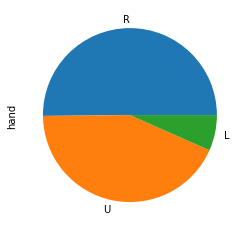

In [31]:
hand_distribution = df_players["hand"].value_counts()
print(hand_distribution)
hand_distribution.plot(kind="pie")

###**Calculate wins and losses**

In [32]:
def count_wins_losses(feature, feature_type):
    if feature_type not in ["winner", "loser"]:
        raise ValueError("The type must be winner or loser")
    
    r = df_matches[feature_type+"_name"].value_counts()
    for player, n in r.iteritems():
        df_players.loc[df_players['name'] == player, feature] = n

In [33]:
df_players.insert(len(df_players.columns), "wins", 0)
df_players.insert(len(df_players.columns), "losses", 0)
df_players["wins"] = df_players["wins"].astype("Int64", errors="ignore")
df_players["losses"] = df_players["losses"].astype("Int64", errors="ignore")

In [34]:
count_wins_losses("wins", "winner")
count_wins_losses("losses", "loser")

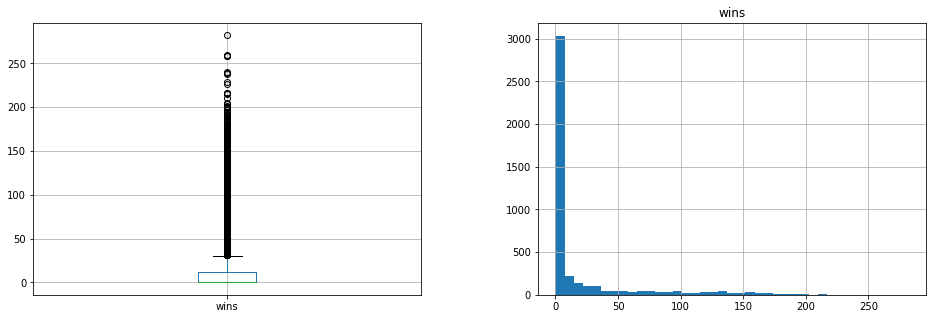

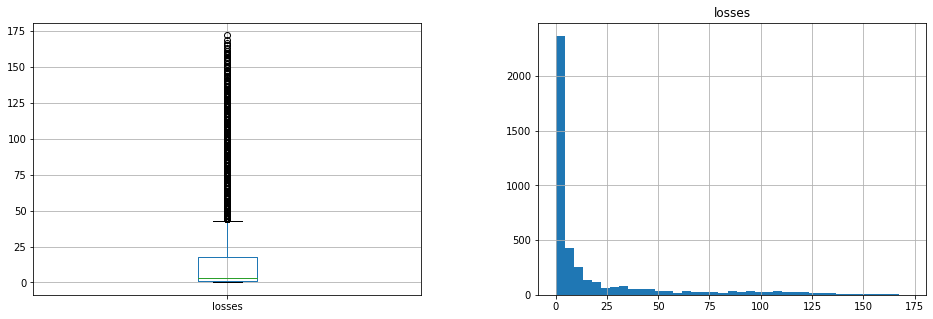

In [35]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="wins", ax=ax1)
df_players.hist(column="wins", ax=ax2, stacked=True, bins=39)
fig.subplots_adjust(wspace=0.3)

fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="losses", ax=ax1)
df_players.hist(column="losses", ax=ax2, stacked=True, bins=39)
fig.subplots_adjust(wspace=0.3)

###**Calculate tournaments won**

In [36]:
def count_finals_by_player(count_winner=True):
    feat = {True: ['winner_name', 'tourneys_won'],
            False: ['loser_name', 'finals_lost']}
    feat = feat[count_winner]
    tourn_finals = df_matches[['tourney_id', feat[0], 'round']].drop_duplicates()
    tourn_finals = tourn_finals[tourn_finals['round'] == 'F']
    n_tournament_won_by_player: pd.Series = tourn_finals[feat[0]].value_counts()
    for x in n_tournament_won_by_player.iteritems():
        player, t_w = x[0], x[1]
        df_players.loc[df_players['name'] == player, feat[1]] = t_w

In [37]:
df_players.insert(len(df_players.columns), "tourneys_won", 0)
df_players["tourneys_won"] = df_players["tourneys_won"].astype("Int64", errors="ignore")
count_finals_by_player()

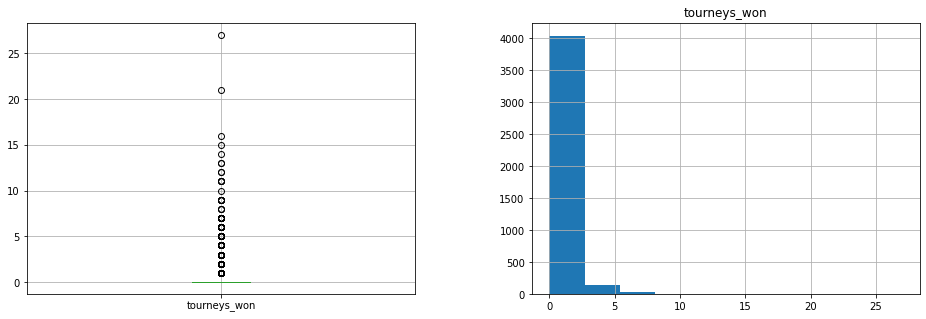

In [38]:
fig, (ax1, ax2) = plt.pyplot.subplots(1, 2, figsize=(16, 5))
df_players.boxplot(column="tourneys_won", ax=ax1)
df_players.hist(column="tourneys_won", ax=ax2, stacked=True, bins=10)
fig.subplots_adjust(wspace=0.3)

###**Calculate statistics for each surface**

In [39]:
def compute_surface_statistics():
    w_match_surface = df_matches[['surface', 'winner_name']]
    l_match_surface = df_matches[['surface', 'loser_name']]
    win_per_surf = []
    for _, surface in w_match_surface['surface'].drop_duplicates().iteritems():
        win_in_surf = w_match_surface[w_match_surface['surface'] == surface]
        los_in_surf = l_match_surface[l_match_surface['surface'] == surface]
        matches = win_in_surf['winner_name'].append(los_in_surf['loser_name']).value_counts()
        win = win_in_surf['winner_name'].value_counts()
        win_per_surf.append((surface, win, matches))
        
    for surface, matches_won, matches in win_per_surf:
        new_attr = 'w_' + surface
        new_attr_matches = 'n_matches_' + surface
        df_players.insert(len(df_players.columns), new_attr, 0)
        df_players.insert(len(df_players.columns), new_attr_matches, 0)
        df_players[new_attr] = df_players[new_attr].astype("Int64", errors="ignore")
        df_players[new_attr_matches] = df_players[new_attr_matches].astype("Int64", errors="ignore")
        for w_ply, n_win in matches_won.iteritems():
            df_players.loc[df_players['name'] == w_ply, new_attr] = n_win
        for ply, n_match in matches.iteritems():
            df_players.loc[df_players['name'] == ply, new_attr_matches] = n_match

In [40]:
compute_surface_statistics()

We need to drop the statistics about the carpet surface since only few matches were played on it and that surface isnt' present anymore in any tournament (source: https://tennisworldlive.com/tennis-tournaments-no-longer-played-carpet/).

In [41]:
df_players[df_players["n_matches_Carpet"]!=0][["w_Carpet"]].sum()

w_Carpet    11
dtype: int64

In [42]:
df_players = df_players.drop(["w_Carpet", "n_matches_Carpet"], axis=1)

###**Calculate each statistics**

In [43]:
def assign_stat_feature(feature, new_feature):
    w_feature = "w_" + feature
    l_feature = "l_" + feature
    w_player_feature = df_matches[['winner_name', w_feature]].rename(columns={"winner_name": "name", w_feature: new_feature})
    l_player_feature = df_matches[['loser_name', l_feature]].rename(columns={'loser_name': 'name', l_feature: new_feature})
    features = w_player_feature.append(l_player_feature)
    features = features.groupby("name").sum()
    df_players.insert(len(df_players.columns), new_feature, 0)
    df_players[new_feature] = df_players[new_feature].astype("Int64", errors="ignore")
    for player, n_feature in features.iterrows():
        df_players.loc[df_players["name"] == player, new_feature] = n_feature[new_feature]

In [44]:
assign_stat_feature("ace", "aces")
assign_stat_feature("df", "double_faults")
assign_stat_feature("svpt", "serve_points")
assign_stat_feature("1stIn", "1st_in")
assign_stat_feature("1stWon", "1st_won")
assign_stat_feature("2ndWon", "2nd_won")
assign_stat_feature("SvGms", "serve_games")
assign_stat_feature("bpSaved", "bp_saved")
assign_stat_feature("bpFaced", "bp_faced")

###**Assign rank**

In [45]:
w_player_rank = df_matches[["tourney_date",'winner_name', 'winner_rank']].rename(columns={'winner_name': 'name', 'winner_rank': 'rank'})
l_player_rank = df_matches[["tourney_date", 'loser_name', 'loser_rank']].rename(columns={'loser_name': 'name', 'loser_rank': 'rank'})
ranks = w_player_rank.append(l_player_rank).drop_duplicates().sort_values(["name", "tourney_date"])
ranks

,tourney_date,name,rank
76205,2017-07-24,aaro pollanen,1559
74244,2016-01-11,aaron addison,1255
72902,2016-02-01,aaron addison,1254
71687,2016-10-24,aaron addison,1037
75587,2016-10-31,aaron addison,1047
...,...,...,...
97905,2019-09-09,zuzana zlochova,342
177465,2020-08-31,zuzana zlochova,317
177121,2021-07-05,zuzana zlochova,344
99909,2021-07-12,zuzana zlochova,351


In [46]:
df_players.insert(len(df_players.columns), "rank", 0)
df_players["rank"] = df_players["rank"].astype("Int64", errors="ignore")

In [47]:
for _, player in df_players.iterrows():
    tourneys_played = ranks[ranks["name"]==player["name"]][["tourney_date", "rank"]]
    last_tourney_played = tourneys_played.iloc[-1]
    df_players.loc[df_players["name"]==player["name"], "rank"] = last_tourney_played["rank"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f138f482750>]],
      dtype=object)

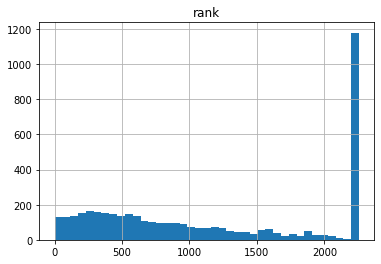

In [48]:
df_players.hist(column="rank", stacked=True, bins=39)

In [49]:
df_players_matches = df_players.drop(index=df_players[df_players["wins"] + df_players["losses"]<10].index)
df_players_matches

,name,sex,birth_date,ioc,ht,hand,wins,losses,tourneys_won,w_Hard,n_matches_Hard,w_Clay,n_matches_Clay,w_Grass,n_matches_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank
0,alexander zverev,M,1997-04-20,DEU,198,R,260,111,16,154,225,83,111,23,35,3227,1626,30089,19491,14530,5284,4861,1338,2197,5
8,frank moser,M,1976-09-23,DEU,193,R,5,6,0,3,6,1,2,1,3,60,22,779,444,324,158,115,53,77,848
13,ruben ramirez hidalgo,M,1978-01-06,ESP,183,R,46,42,0,11,19,35,69,0,0,328,307,6107,3509,2436,1255,915,383,624,341
14,tommy haas,M,1978-04-03,DEU,188,R,6,14,0,0,3,4,12,2,5,95,82,1710,1047,719,357,256,111,162,248
15,toshihide matsui,M,1978-04-19,JPN,180,R,20,33,0,19,49,1,4,0,0,292,188,3285,1910,1349,681,507,190,310,752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4253,alexandar lazov,M,1990-07-09,BGR,189,U,17,15,0,3,9,14,23,0,0,130,115,2047,1267,860,375,323,141,231,828
4254,david o hare,M,1990-06-01,IRL,174,U,4,11,0,3,13,0,0,1,2,86,97,1070,657,462,182,157,64,102,2221
4255,kuan-yi lee,M,1996-09-09,TWN,182,R,16,18,0,16,33,0,1,0,0,94,67,2138,1451,954,342,340,133,227,573
4256,ben patael,M,1997-06-09,ISR,175,U,16,23,0,10,22,6,17,0,0,175,116,2638,1618,1065,499,409,153,272,562


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f138fab0b50>]],
      dtype=object)

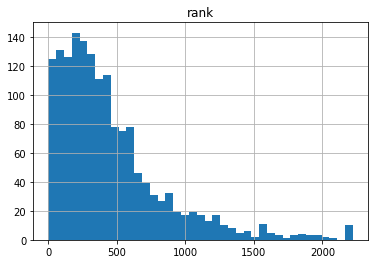

In [50]:
df_players_matches.hist(column="rank", stacked=True, bins=39)

###**Assign ranking points**

In [51]:
w_player_rank_points = df_matches[["tourney_date",'winner_name', 'winner_rank_points']]\
.rename(columns={'winner_name': 'name', 'winner_rank_points': 'rank_points'})
l_player_rank_points = df_matches[["tourney_date", 'loser_name', 'loser_rank_points']]\
.rename(columns={'loser_name': 'name', 'loser_rank_points': 'rank_points'})
rank_points = w_player_rank_points.append(l_player_rank_points).drop_duplicates().sort_values(["name", "tourney_date"])
rank_points

,tourney_date,name,rank_points
76205,2017-07-24,aaro pollanen,2
74244,2016-01-11,aaron addison,6
72902,2016-02-01,aaron addison,6
71687,2016-10-24,aaron addison,10
75587,2016-10-31,aaron addison,10
...,...,...,...
97905,2019-09-09,zuzana zlochova,144
177465,2020-08-31,zuzana zlochova,166
177121,2021-07-05,zuzana zlochova,155
99909,2021-07-12,zuzana zlochova,157


In [52]:
df_players.insert(len(df_players.columns), "rank_points", 0)
df_players["rank_points"] = df_players["rank_points"].astype("Int64", errors="ignore")

In [53]:
for _, player in df_players.iterrows():
    tourneys_played = rank_points[rank_points["name"]==player["name"]][["tourney_date", "rank_points"]]
    last_tourney_played = tourneys_played.iloc[-1]
    df_players.loc[df_players["name"]==player["name"], "rank_points"] = last_tourney_played["rank_points"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f138f677190>]],
      dtype=object)

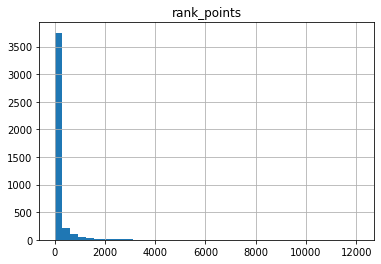

In [54]:
df_players.hist(column="rank_points", stacked=True, bins=39)

##**Correlations before introducing new features**

In [55]:
df_players.head()

,name,sex,birth_date,ioc,ht,hand,wins,losses,tourneys_won,w_Hard,n_matches_Hard,w_Clay,n_matches_Clay,w_Grass,n_matches_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank,rank_points
0,alexander zverev,M,1997-04-20,DEU,198,R,260,111,16,154,225,83,111,23,35,3227,1626,30089,19491,14530,5284,4861,1338,2197,5,7263
1,jeff greenwald,M,1966-11-10,USA,192,R,0,1,0,0,1,0,0,0,0,0,5,90,51,31,18,10,10,14,2221,0
2,agustin moreno,M,1967-03-31,MEX,180,R,1,3,0,0,2,1,2,0,0,8,31,231,117,82,49,35,16,29,2221,0
3,martin damm,M,2003-09-30,USA,198,L,2,5,0,2,4,0,3,0,0,26,28,593,322,233,111,86,38,64,699,32
4,wei yu su,M,1976-01-12,TWN,178,R,0,1,0,0,1,0,0,0,0,2,4,98,57,35,21,13,11,15,2221,0


In [56]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4255 entries, 0 to 4258
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4255 non-null   object
 1   sex              4255 non-null   object
 2   birth_date       4199 non-null   object
 3   ioc              4255 non-null   object
 4   ht               4255 non-null   Int64 
 5   hand             4255 non-null   object
 6   wins             4255 non-null   Int64 
 7   losses           4255 non-null   Int64 
 8   tourneys_won     4255 non-null   Int64 
 9   w_Hard           4255 non-null   Int64 
 10  n_matches_Hard   4255 non-null   Int64 
 11  w_Clay           4255 non-null   Int64 
 12  n_matches_Clay   4255 non-null   Int64 
 13  w_Grass          4255 non-null   Int64 
 14  n_matches_Grass  4255 non-null   Int64 
 15  aces             4255 non-null   Int64 
 16  double_faults    4255 non-null   Int64 
 17  serve_points     4255 non-null   

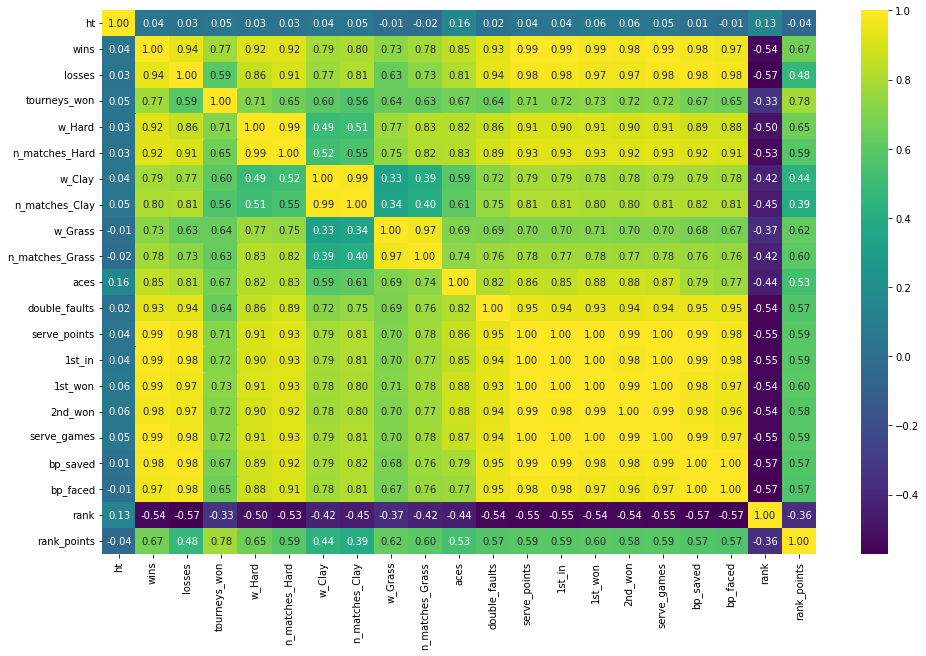

In [57]:
plt.pyplot.figure(figsize=(16, 10))
sn.heatmap(df_players.corr(), annot=True, fmt=".2f", cmap='viridis')

In [59]:
df_players.loc[df_players["name"]=="ivo karlovic"]

,name,sex,birth_date,ioc,ht,hand,wins,losses,tourneys_won,w_Hard,n_matches_Hard,w_Clay,n_matches_Clay,w_Grass,n_matches_Grass,aces,double_faults,serve_points,1st_in,1st_won,2nd_won,serve_games,bp_saved,bp_faced,rank,rank_points
18,ivo karlovic,M,1979-02-28,HRV,208,R,101,103,3,67,132,14,34,20,38,4222,966,17745,11492,9407,3455,2879,559,783,205,352


There are many higly-correlated features, we need to build new indicators from the ones we have and we have to drop those who we think are redundant or useless for the clustering analysis.

In [63]:
df_players['n_matches'] = df_players['wins'] + df_players['losses']
df_players['p_wins'] = np.round(df_players["wins"] / df_players["n_matches"]*100, 2)

# percentage of wins on each surface
df_players['p_wins_Hard'] = np.round(df_players["w_Hard"] / df_players["n_matches_Hard"]*100, 2)
df_players['p_wins_Clay'] = np.round(df_players["w_Clay"] / df_players["n_matches_Clay"]*100, 2)
df_players['p_wins_Grass'] = np.round(df_players["w_Grass"] / df_players["n_matches_Grass"]*100, 2)

# features for the aces
df_players['mean_aces'] = np.floor(df_players["aces"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_aces'] = np.round(df_players["double_faults"] / (df_players["1st_won"] + df_players["2nd_won"])*100, 2)

# features for the double faults
df_players['mean_double_faults'] = np.floor(df_players["double_faults"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_double_faults'] = np.round(df_players["double_faults"] / (df_players["serve_points"] - df_players["double_faults"] + df_players["2nd_won"])*100, 2)

# features for the first service in
df_players['mean_1st_in'] = np.floor(df_players["1st_in"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_1st_in'] = np.round(df_players["1st_in"] / df_players["serve_points"]*100, 2)
df_players['mean_1st_won'] = np.floor(df_players["1st_won"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_1st_won'] = np.round(df_players["1st_won"] / df_players["1st_in"]*100, 2)

df_players['mean_2nd_won'] = np.floor(df_players["2nd_won"] / df_players["n_matches"]).astype('Int32', errors='raise')

# se usiamo p_double_faults, p_2nd_won è inutile
# df_players['p_2nd_won'] = np.round(df_players["2nd_won"] / (df_players["double_faults"] + df_players["2nd_won"])*100, 2)

# features for the breakpoints saved
df_players['mean_bp_saved'] = np.floor(df_players["bp_saved"] / df_players["n_matches"]).astype('Int32', errors='raise')
df_players['p_bp_saved'] = np.round(df_players["bp_saved"] / df_players["bp_faced"]*100, 2)

# df_players['mean_bp_faced'] = np.floor(df_players["bp_faced"] / df_players["n_matches"]).astype('Int32', errors='raise')
# df_players['mean_serve_games'] = np.floor(df_players["serve_games"] / df_players["n_matches"]).astype('Int32', errors='raise')
# df_players['mean_serve_points'] = np.floor(df_players["serve_points"] / df_players["n_matches"]).astype('Int32', errors='raise')

df_players=df_players.fillna(0)

KeyError: ignored

In [60]:
df_players = df_players.drop(["losses", "n_matches_Hard", "n_matches_Clay", "n_matches_Grass",
                              "aces", "double_faults", "serve_points", "1st_in", "1st_won",
                              "2nd_won", "serve_games", "bp_faced", "n_matches"], axis=1)

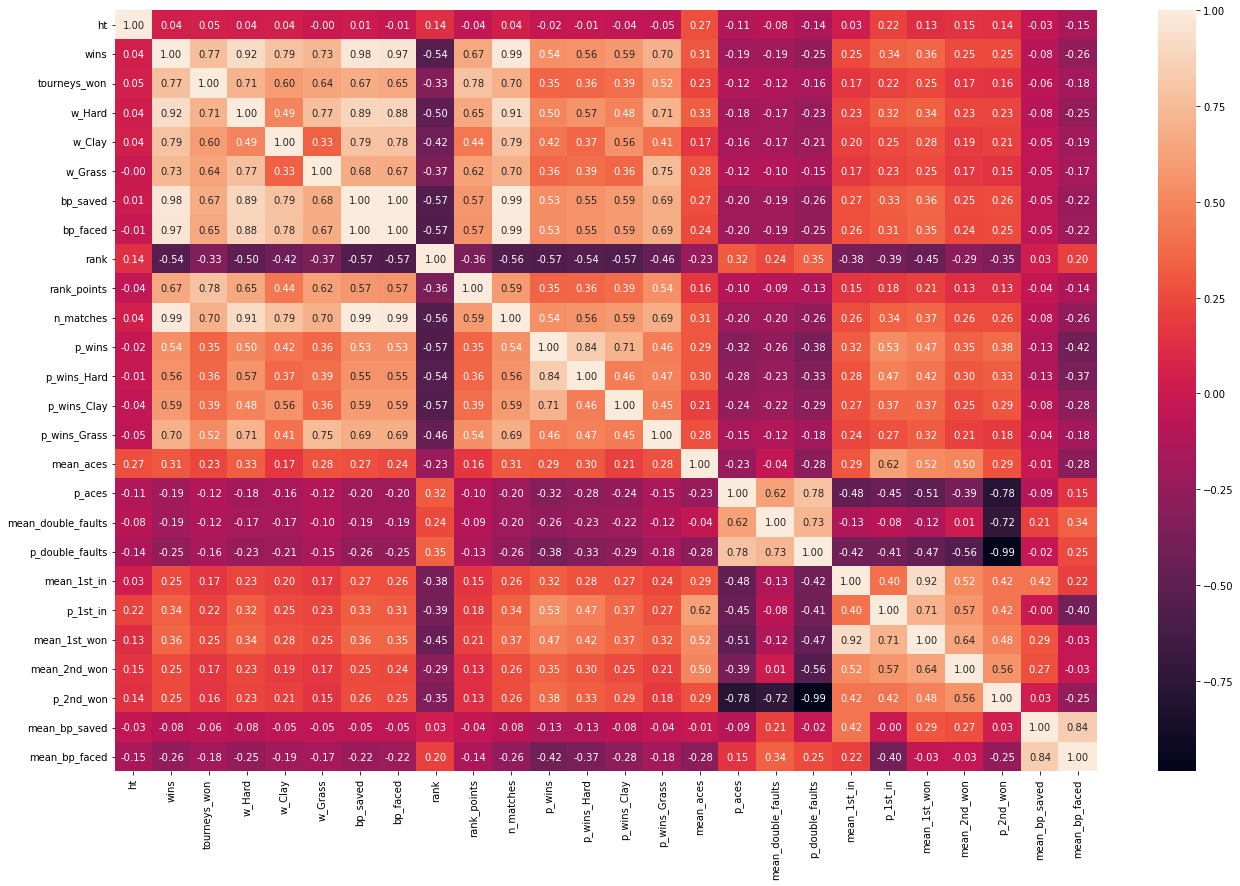

In [61]:
plt.pyplot.figure(figsize=(22, 14))
sn.heatmap(df_players.corr(), annot=True, fmt=".2f")

In [62]:
df_players

,name,sex,birth_date,ioc,ht,hand,wins,tourneys_won,w_Hard,w_Clay,w_Grass,bp_saved,bp_faced,rank,rank_points,n_matches,p_wins,p_wins_Hard,p_wins_Clay,p_wins_Grass,mean_aces,p_aces,mean_double_faults,p_double_faults,mean_1st_in,p_1st_in,mean_1st_won,mean_2nd_won,p_2nd_won,mean_bp_saved,mean_bp_faced
0,alexander zverev,M,1997-04-20,DEU,198,R,260,16,154,83,23,1338,2197,5,7263,371,70.08,68.44,74.77,65.71,8,8.21,4,23.53,52,74.55,39,14,76.47,3,5
1,jeff greenwald,M,1966-11-10,USA,167,R,0,0,0,0,0,10,14,2221,0,1,0.00,0.00,0.00,0.00,0,10.20,5,21.74,51,60.78,31,18,78.26,10,14
2,agustin moreno,M,1967-03-31,MEX,180,R,1,0,0,1,0,16,29,2221,0,4,25.00,0.00,50.00,0.00,2,23.66,7,38.75,29,70.09,20,12,61.25,4,7
3,martin damm,M,2003-09-30,USA,200,L,2,0,2,0,0,38,64,699,32,7,28.57,50.00,0.00,0.00,3,8.14,4,20.14,46,72.36,33,15,79.86,5,9
4,wei yu su,M,1976-01-12,TWN,191,R,0,0,0,0,0,11,15,2221,0,1,0.00,0.00,0.00,0.00,2,7.14,4,16.00,57,61.40,35,21,84.00,11,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4254,david o hare,M,1990-06-01,IRL,181,U,4,0,3,0,1,64,102,2221,0,15,26.67,23.08,0.00,50.00,5,15.06,6,34.77,43,70.32,30,12,65.23,4,6
4255,kuan-yi lee,M,1996-09-09,TWN,173,R,16,0,16,0,0,133,227,573,42,34,47.06,48.48,0.00,0.00,2,5.17,1,16.38,42,65.75,28,10,83.62,3,6
4256,ben patael,M,1997-06-09,ISR,179,U,16,0,10,6,0,153,272,562,45,39,41.03,45.45,35.29,0.00,4,7.42,2,18.86,41,65.82,27,12,81.14,3,6
4257,andres artunedo martinavarro,M,1993-09-14,ESP,182,R,13,0,13,0,0,123,205,390,40,33,39.39,40.62,0.00,0.00,7,6.32,2,17.59,43,75.52,33,13,82.41,3,6
